In [ ]:
%matplotlib inline
import pandas as pd
import networkx as nx
import ujson as json
import metis
import random
from matplotlib import pyplot as plt
from pprint import pprint

In [137]:
dataset="ukraine"

In [138]:
def to_dataframe(raw_file_path):
    with open(raw_file_path, 'r') as f:
        rows = []
        for l in f:            
            t = json.loads(l)    
            if t['rtds_tweet']['retweet_type'] == 1:
                rows.append({
                    'retweeter': t['rtds_tweet']['user_id'],
                    'retweetee': t['rtds_tweet']['retweeted_status_user_id'],
                    'created_at': t['rtds_tweet']['created_at_timestamp']
                        })
        return pd.DataFrame.from_records(rows)

In [139]:
df = to_dataframe('data/tweets_{}.txt'.format(dataset))
df.to_pickle('data/{}.pkl'.format(dataset))

In [140]:
def build_retweet_graphraph(raw_file_path):
    g = nx.Graph()
    with open(raw_file_path, 'r') as f:
        for l in f:            
            t = json.loads(l)    
            if t['rtds_tweet']['retweet_type'] == 1:
                g.add_edge(t['rtds_tweet']['user_id'],
                           t['rtds_tweet']['retweeted_status_user_id'],
                           created_at=t['rtds_tweet']['created_at_timestamp'])
    return g

In [141]:
def get_largest_connected_subgraph(g):
    ccs = nx.connected_components(g)
    nodes = max(ccs, key=len)
    return g.subgraph(nodes)


In [142]:
g = build_retweet_graph('data/tweets_{}.txt'.format(dataset))
# g = nx.read_gpickle('data/{}.gpkl'.format(dataset))

In [143]:
if True:
    nx.write_gpickle(g, 'data/{}.gpkl'.format(dataset))
if True:    
    nx.write_graphml(g, 'output/{}.graphml'.format(dataset))

In [144]:
cc_g = get_largest_connected_subgraph(g)
print(g.number_of_nodes(), g.number_of_edges())
print(cc_g.number_of_nodes(), cc_g.number_of_edges())
g = cc_g

56264 105586
47337 98870


In [145]:
# take the core sub graph
sample_size = 2500
if g.number_of_nodes() > sample_size:    
    nodes = [n for n in g.nodes() if g.degree(n) > 1]  # prevent the dangling nodes from spreading out in the figure
    print(len(nodes))
    if len(nodes) > sample_size:
        nodes = random.sample(nodes, sample_size)
    g = nx.subgraph(g, nodes)
    g = get_largest_connected_subgraph(g)

16664


In [146]:
print(g.number_of_nodes())
print(g.number_of_edges())

883
1313


In [147]:
cuts, parts = metis.part_graph(g)
print(cuts)

95


In [148]:
from forceatlas import forceatlas2_layout

In [149]:
pos = forceatlas2_layout(g, iterations=100)

100%|██████████| 100/100 [00:16<00:00,  5.10it/s]


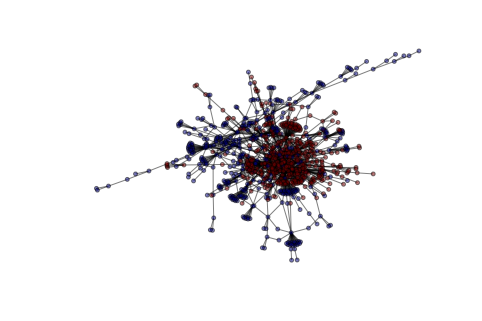

In [150]:
fig = nx.draw(g, pos=pos, with_label=False, node_color=parts, node_size=15, alpha=0.5)

In [104]:
fig = plt.gcf()
fig.savefig('figs/{}.pdf'.format(dataset))

In [105]:
# g = nx.barabasi_albert_graph(50000, 3)
# nx.write_gpickle(g, 'data/barabasi.pkl')